In [1]:
import finesse
from finesse.analysis.actions import Minimize, Maximize, TemporaryParameters, Xaxis, Change, Series
from finesse_virgo.virgo import Virgo
import matplotlib.pyplot as plt

finesse.configure(plotting=True)

In [2]:
# utility functions

def get_darm(model, axis=[.5, 1000, 200]):
    kat = model.deepcopy()
    kat.parse("""
    fsig(1)
    sgen sigQ NE.mech.F_z phase=180
    sgen sigI WE.mech.F_z

    ad darm B1p_56.I f=fsig.f
    """)
    return kat.run(Xaxis(kat.fsig.f, "log", *axis))


def pretune_off(model):
    """
    Pre-tune the model. As for SRCL pre-tunig: restore the SR mirror and set an offset of -90 (no optimizers involved)
    """
    midx = model.eom56.midx
    model.run(
        TemporaryParameters(
            Series(
                Change({"eom6.midx": 0, "eom56.midx": 0, "eom8.midx": 0, "SR.misaligned": True, "PR.misaligned": True,  "SRAR.misaligned": True, "PRAR.misaligned": True}),
                # Maximise arm power
                Maximize("B7_DC", "NE_z.DC", bounds=[-180,180], tol=1e-14),
                Maximize("B8_DC", "WE_z.DC", bounds=[-180,180], tol=1e-14),
                # Minimise dark fringe power
                Minimize("B1_DC", "MICH.DC", bounds=[-180,180], tol=1e-14),
                # Bring in PR
                Change({"PR.misaligned": False}),
                # Maximise PRC power
                Maximize("CAR_AMP_BS", "PRCL.DC", bounds=[-180,180], tol=1e-14),
                # Bring in SR
                Change({"SR.misaligned": False}),
                # Offset by 90°
                Change({"SRCL.DC": -90})),
            exclude=("PR.phi", "NI.phi", "NE.phi", "WI.phi", "WE.phi", "SR.phi", "NE_z.DC", "WE_z.DC", "MICH.DC", "PRCL.DC", "SRCL.DC")
        )
    )

We pretune the KatScript using two different mathods for pre-tuning SRCL.
1) We maximize `B1_DC` and then set an offset of -90°, which is what we used so far.
2) We set on offset of -90° straight away without using optimizers.

In [3]:
virgo = Virgo() #   creating a model using adv+ common katscript

In [4]:
virgo.model.modes(maxtem=4)
virgo.pretune() # pretuning by maximizing B1 for srcl + setting a 90° offset
out_b1 = get_darm(virgo.model)

pretune_off(virgo.model) # set an offset on srcl of -90°
out_off = get_darm(virgo.model)

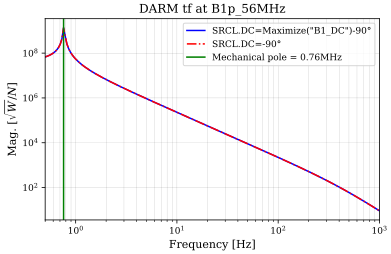

In [5]:
plt.figure()
plt.loglog(
    out_b1.x1,
    abs(out_b1['darm']),
    label='SRCL.DC=Maximize("B1_DC")-90°'
)
plt.loglog(
    out_off.x1,
    abs(out_off['darm']),
    label='SRCL.DC=-90°',
    ls='-.'
)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mag. [$\sqrt{W}/N$]')
plt.title('DARM tf at B1p_56MHz')
plt.axvline(.76, label='Mechanical pole = 0.76MHz', color='g')
plt.legend()
#plt.savefig('srcl_pretuning.png', dpi=300)
plt.show()